# 1. 데이터: 기상 데이터
- 기상 정보에 관한 데이터 셋
- 현재 시점에서의 기상 상태를 나타내는 총 14개의 독립변수를 갖고 있음
- 24시간 후의 기온(섭씨)이 올라갈지 떨어질지 분류하는 것이 목적

In [ ]:
!git clone https://github.com/kc9410/Variable_Selection_and_Dimensionality_Reduction.git

In [24]:
import numpy as np
import pandas as pd
weather_data = pd.read_csv('/content/Variable_Selection_and_Dimensionality_Reduction/data/weather_dataset.csv')

In [25]:
weather_data.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [26]:
#10분 단위로 측정된 시계열 데이터 셋
weather_data.loc[:10,'Date Time']

0     01.01.2009 00:10:00
1     01.01.2009 00:20:00
2     01.01.2009 00:30:00
3     01.01.2009 00:40:00
4     01.01.2009 00:50:00
5     01.01.2009 01:00:00
6     01.01.2009 01:10:00
7     01.01.2009 01:20:00
8     01.01.2009 01:30:00
9     01.01.2009 01:40:00
10    01.01.2009 01:50:00
Name: Date Time, dtype: object

In [27]:
# Label 분리 및 불필요한 변수 제거
weather_labels = weather_data.loc[:,'T (degC)']
weather_data = weather_data.drop('Date Time',axis=1)

# 2. Data Split
- 시계열 데이터는 순서 정보가 필요할 경우 무작위 추출 방식을 사용할 수 없음
- 24시간 후의 기온을 예측하는 것이 목적이므로 시계열 순서를 보존하면서 Train Set과 Test Set을 구성함

In [28]:
#10분*144 = 24시간
idx = np.arange(weather_data.shape[0]-144)

#Train:Test = 8:2
tr_ratio = 0.8 
tr_point = int(len(idx)*tr_ratio)

train_idx = idx[0:tr_point]
test_idx = idx[tr_point:]

In [29]:
weather_X_train = weather_data.iloc[train_idx]
weather_y_train = weather_labels[train_idx+144].reset_index(drop=True)-weather_labels[train_idx].reset_index(drop=True)>=0

weather_X_test = weather_data.iloc[test_idx]
weather_y_test = weather_labels[test_idx+144].reset_index(drop=True)-weather_labels[test_idx].reset_index(drop=True)>=0

In [30]:
#Malware Classification 데이터 셋 load
malware_data = pd.read_csv('./data/Malwares Classification.csv')

In [31]:
malware_data = malware_data.dropna(axis=0)
malware_labels = malware_data.loc[:,'class']
malware_data = malware_data.drop('class',axis=1)

In [32]:
from sklearn.model_selection import train_test_split
malware_X_train, malware_X_test, malware_y_train, malware_y_test = train_test_split(malware_data, malware_labels, test_size=0.2, random_state=42)

# 3. 모델 학습 및 평가
- 랜덤 포레스트 모델을 활용하여 데이터를 학습하고 분류 성능을 측정함
- 기상 데이터 셋과 malware classification 데이터 셋에 대한 결과를 비교함

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
# 기상 데이터 
weather_ranfo = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=10)
weather_ranfo.fit(weather_X_train, weather_y_train)
# malware 데이터
malware_ranfo = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=10)
malware_ranfo.fit(malware_X_train, malware_y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1)

In [35]:
weather_pred_train = weather_ranfo.predict(weather_X_train)
weather_pred_test  = weather_ranfo.predict(weather_X_test)
weather_acc_train  = np.sum(weather_pred_train==weather_y_train)/len(weather_y_train)
weather_acc_test   = np.sum(weather_pred_test==weather_y_test)/len(weather_y_test)

malware_pred_train = malware_ranfo.predict(malware_X_train)
malware_pred_test  = malware_ranfo.predict(malware_X_test)
malware_acc_train  = np.sum(malware_pred_train==malware_y_train)/len(malware_y_train)
malware_acc_test   = np.sum(malware_pred_test==malware_y_test)/len(malware_y_test)

In [36]:
print("weather_train ACC:", weather_acc_train)
print("weather_test ACC:", weather_acc_test)
print("malware_train ACC:", malware_acc_train)
print("malware_test ACC:", malware_acc_test)

weather_train ACC: 0.8980735331150843
weather_test ACC: 0.5553877139979859
malware_train ACC: 0.9964011516314779
malware_test ACC: 0.989443378119002


# 4. PCA & t-SNE
- 차원 축소 기법인 PCA와 t-SNE를 활용하여 2차원 상에서의 class별 산포를 확인함
- 기상 데이터 셋과 malware classification 데이터 셋의 결과를 비교함
- PCA 기법을 활용하여 차원을 축소하였을 때, 분류 성능을 확인함

### Step 1. PCA를 활용한 2차원 산포 비교
- PCA는 데이터의 분산을 가장 잘 설명하는 새로운 직교 좌표계를 찾아 데이터의 차원을 축소하는 기법
- 이 때, 정규화되지 않은 데이터 셋을 사용할 경우 절대값의 크기가 큰 변수에 크게 영향을 받게 되는 문제가 발생함
- 따라서 정규화를 사용한 후 PCA를 하는 것이 좋음

![image.png](https://mblogthumb-phinf.pstatic.net/MjAxNzEyMDVfMTQy/MDAxNTEyNDc1NDY0MDQ0.WLLjdE3u-j6ff1i0jlO4NqcJvpUF0RKqyZ8ntT-hLX8g.aD17OGIXjxME6GgTsoIsJ__dIrESgJjkoEyq7iQgA1Ig.PNG.sanghan1990/1-1.png?type=w800)

In [86]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [87]:
#weather 데이터 셋 PCA 결과, 정규화X
pca = PCA(n_components=2)
weather_pc = pca.fit_transform(weather_X_test)

In [88]:
#pca의 결과 주성분 축
#(n_components, n_features)
print(pca.components_)
print(np.sum(pca.components_[0]**2))
print(np.sum(pca.components_[1]**2))

[[-7.98236560e-03 -5.12701758e-03 -4.47439401e-03  1.29038502e-03
   2.78062872e-02 -4.70662979e-03  8.61733469e-04 -5.56826820e-03
   6.00206043e-04  9.58032458e-04  1.16830773e-02 -2.77867972e-03
  -3.96153343e-03  9.99449865e-01]
 [-1.00192681e-01  1.53107817e-01  1.61867289e-01  2.47392675e-02
  -5.43941919e-01  1.50136391e-01  1.64506481e-02  1.33687284e-01
   1.10424854e-02  1.76179237e-02 -7.74812658e-01  2.12903388e-02
   3.50460391e-02  2.64806718e-02]]
1.0
1.0


In [89]:
#pca 설명 가능한 분산량
print(pca.explained_variance_ratio_)

[0.89351724 0.08519926]


In [90]:
weather_pc[:10]

array([[ -28.38816464,  -24.59051672],
       [ -51.93965728,  -22.26833022],
       [-134.71045555,  -21.83048628],
       [-131.71413817,  -19.57992184],
       [-165.22294516,  -13.77797787],
       [-124.37121136,   -6.50083988],
       [-157.49222758,   -6.29242688],
       [-160.85185436,   -8.38309364],
       [-160.28692469,   -7.77440333],
       [-167.30717844,   -4.88786501]])

Text(0, 0.5, 'component 1')

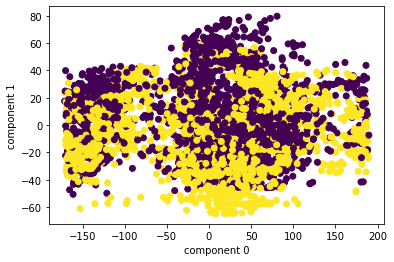

In [91]:
plt.scatter(weather_pc[:,0],weather_pc[:,1],c=weather_y_test)
plt.xlabel('component 0')
plt.ylabel('component 1')

In [92]:
#malware 데이터 셋 PCA 결과, 정규화X
pca = PCA(n_components=2)
malware_pc = pca.fit_transform(malware_X_test)

In [93]:
#pca 설명 가능한 분산량
print(pca.explained_variance_ratio_)

[0.98123404 0.01459948]


In [94]:
malware_pc[0:10]

array([[-4531610.25296366,  -597221.65922088],
       [-4171133.13358315,  -592004.89555272],
       [-4455305.9671626 ,  -593699.66006293],
       [-4220921.89762247,  -591960.35677369],
       [-4682329.56906789,  -597311.68851171],
       [-4682529.4021186 ,  -599227.26922682],
       [-4369894.96380091,  -596024.69066158],
       [-4682530.4555337 ,  -599250.26598508],
       [-4682347.66212633,  -467103.97844193],
       [-4682241.24648347,  -596826.24174409]])

Text(0, 0.5, 'component 1')

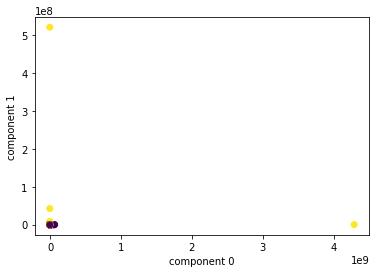

In [95]:
plt.scatter(malware_pc[:,0],malware_pc[:,1],c=malware_y_test)
plt.xlabel('component 0')
plt.ylabel('component 1')

In [96]:
# train 데이터를 기반으로 train/test 데이터에 대하여 standard scaling 적용 (평균 0, 분산 1) 
from sklearn.preprocessing import StandardScaler
weather_scaler = StandardScaler()
weather_scaler = weather_scaler.fit(weather_X_train)

malware_scaler = StandardScaler()
malware_scaler = malware_scaler.fit(malware_X_train)

In [97]:
weather_X_train_s = pd.DataFrame(weather_scaler.transform(weather_X_train),columns=weather_X_train.columns,index=weather_X_train.index)
weather_X_test_s  = pd.DataFrame(weather_scaler.transform(weather_X_test),columns=weather_X_test.columns,index=weather_X_test.index)
malware_X_train_s = pd.DataFrame(malware_scaler.transform(malware_X_train),columns=malware_X_train.columns,index=malware_X_train.index)
malware_X_test_s  = pd.DataFrame(malware_scaler.transform(malware_X_test),columns=malware_X_test.columns,index=malware_X_test.index)

Text(0, 0.5, 'component 1')

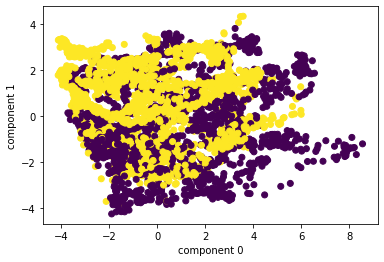

In [98]:
#weather 데이터 셋 PCA 결과, 정규화O
pca = PCA(n_components=2)
weather_pc = pca.fit_transform(weather_X_test_s)

In [99]:
#pca 설명 가능한 분산량
print(pca.explained_variance_ratio_)

[0.51580145 0.2659773 ]


In [100]:
weather_pc[:10]

array([[-1.63380517,  2.24025402],
       [-1.4643003 ,  2.08149382],
       [-1.04627415,  2.35074258],
       [-1.03089231,  2.27645897],
       [-0.4524125 ,  2.20504295],
       [ 0.05724166,  2.21842285],
       [ 0.48365256,  2.74043699],
       [ 0.45499271,  2.81689582],
       [ 0.49484511,  2.79628802],
       [ 0.80966292,  2.86524469]])

Text(0, 0.5, 'component 1')

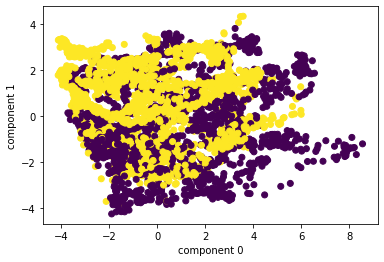

In [101]:
plt.scatter(weather_pc[:,0],weather_pc[:,1],c=weather_y_test)
plt.xlabel('component 0')
plt.ylabel('component 1')

In [102]:
#malware 데이터 셋 PCA 결과, 정규화O
pca = PCA(n_components=2)
malware_pc = pca.fit_transform(malware_X_test_s)

In [103]:
#pca 설명 가능한 분산량
print(pca.explained_variance_ratio_)

[0.14911463 0.10845806]


In [104]:
malware_pc[0:10]

array([[-0.49400327,  0.4232356 ],
       [-1.07363122,  4.07120596],
       [-1.13496719,  3.562694  ],
       [-0.93852655,  3.55493056],
       [ 0.08837547, -2.2132344 ],
       [-0.3922943 , -0.08427469],
       [-0.04421028, -1.10171863],
       [-0.39297981, -0.08909207],
       [ 0.61426044, -1.46118528],
       [ 0.01605158, -1.24410061]])

Text(0, 0.5, 'component 1')

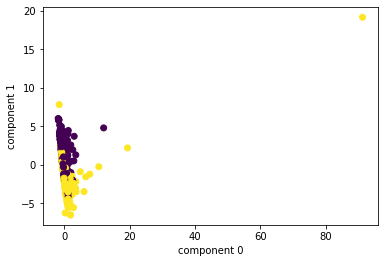

In [105]:
plt.scatter(malware_pc[:,0],malware_pc[:,1],c=malware_y_test)
plt.xlabel('component 0')
plt.ylabel('component 1')

### Step 2. t-SNE를 활용한 2차원 산포 비교
- SNE 고차원 공간상에서의 이웃간의 거리 정보를 저차원 공간상에서도 잘 보존하도록 차원을 축소하는 기법
- 정규 분포를 사용하는 SNE와 달리 t-SNE는 t 분포를 사용하면 좀 더 멀리있는 객체에 대한 정보까지도 잘 반영함
- 선형 방식으로 정사영하는 PCA와 달리 데이터의 manifold를 고려하므로 시각화 결과 데이터가 더욱 잘 분리되는 경향이 있음

![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_t_sne_perplexity_001.png)

In [108]:
from sklearn.manifold import TSNE

In [128]:
weather_tsne = TSNE(n_components = 2, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=0).fit_transform(weather_X_test_s)

Text(0, 0.5, 'component 1')

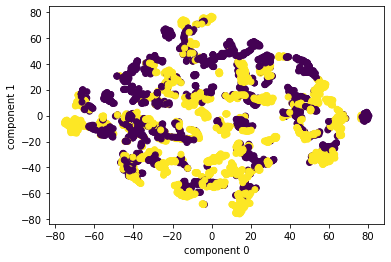

In [129]:
plt.scatter(weather_tsne[:,0],weather_tsne[:,1],c=weather_y_test)
plt.xlabel('component 0')
plt.ylabel('component 1')

In [130]:
malware_tsne = TSNE(n_components = 2, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=0).fit_transform(malware_X_test_s)

Text(0, 0.5, 'component 1')

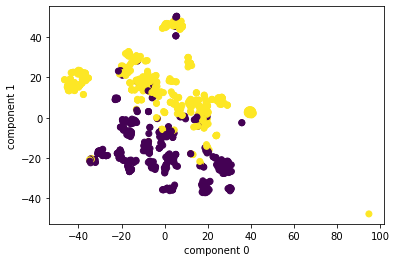

In [131]:
plt.scatter(malware_tsne[:,0],malware_tsne[:,1],c=malware_y_test)
plt.xlabel('component 0')
plt.ylabel('component 1')

### Perplexity에 따른 분포 비교
- perplexity가 높을 수록 더 넓은 범위의 이웃들을 고려할 수 있음
- 반대로 perplexity가 낮다면 좁은 범위의 이웃들만 고려하게 됨
- 따라서 perplexity를 너무 낮게 설정하면 crowding problem이 발생할 수 있음
- 일반적으로 5~50 정도의 값이면 적당하고, 이 값에 크게 민감하지 않음

In [144]:
malware_tsne = TSNE(n_components = 2, perplexity=10, learning_rate=200.0, n_iter=1000, random_state=0).fit_transform(malware_X_test_s)

Text(0, 0.5, 'component 1')

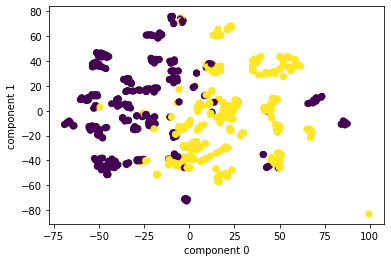

In [145]:
plt.scatter(malware_tsne[:,0],malware_tsne[:,1],c=malware_y_test)
plt.xlabel('component 0')
plt.ylabel('component 1')

### Step 3. PCA Variable Extraction
- PCA를 활용하여 variable extraction을 진행한 후 분류 모델을 학습함
- 기존 분류 모델과의 성능 비교를 통해 PCA variable extracion 효과를 확인함

In [201]:
#weather 데이터 셋 PCA 결과, 정규화O
pca = PCA(n_components=len(weather_X_train_s.columns))
weather_pc = pca.fit_transform(weather_X_train_s)

In [202]:
#pca 설명 가능한 분산량
print(pca.explained_variance_ratio_)

[5.89288157e-01 1.55053501e-01 1.12909695e-01 6.93158831e-02
 5.46323618e-02 1.09267045e-02 4.96802472e-03 2.83673180e-03
 6.19514028e-05 4.94034068e-06 1.72200362e-06 1.99264934e-07
 7.02863743e-08 5.71440900e-08]


In [203]:
weather_X_train_new = pca.transform(weather_X_train_s)
weather_X_test_new  = pca.transform(weather_X_test_s)

In [204]:
n_feature = 2

In [207]:
weather_ranfo_new = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=15)
weather_ranfo_new.fit(weather_X_train_new[:,:n_feature], weather_y_train)

RandomForestClassifier(max_depth=15, n_jobs=-1)

In [208]:
weather_pred_train_new = weather_ranfo_new.predict(weather_X_train_new[:,:n_feature])
weather_pred_test_new  = weather_ranfo_new.predict(weather_X_test_new[:,:n_feature])
weather_acc_train_new  = np.sum(weather_pred_train_new==weather_y_train)/len(weather_y_train)
weather_acc_test_new   = np.sum(weather_pred_test_new==weather_y_test)/len(weather_y_test)

In [209]:
print("weather_train ACC:", weather_acc_train_new)
print("weather_test ACC:", weather_acc_test_new)

weather_train ACC: 0.881578947368421
weather_test ACC: 0.5677240684793555


In [214]:
#malware 데이터 셋 PCA 결과, 정규화O
pca = PCA(n_components=len(malware_X_train_s.columns))
malware_pc = pca.fit_transform(malware_X_train_s)

In [215]:
#pca 설명 가능한 분산량
print(pca.explained_variance_ratio_)

[1.11642725e-01 6.98805839e-02 5.27213105e-02 4.91276379e-02
 4.37293837e-02 4.27818626e-02 3.94437575e-02 3.51935167e-02
 3.11841968e-02 2.61672198e-02 2.43674420e-02 2.30859647e-02
 2.12457192e-02 1.98077975e-02 1.86451049e-02 1.79846045e-02
 1.76488781e-02 1.72531292e-02 1.71078652e-02 1.69309913e-02
 1.68685953e-02 1.67465376e-02 1.66932137e-02 1.61924367e-02
 1.56995209e-02 1.54027181e-02 1.49687517e-02 1.40748364e-02
 1.37243438e-02 1.33655067e-02 1.24027150e-02 1.18865566e-02
 1.11678859e-02 1.05579915e-02 9.76268719e-03 9.43525142e-03
 8.87827247e-03 7.97044176e-03 7.69389493e-03 7.13159093e-03
 6.42931426e-03 6.27662638e-03 6.02202443e-03 6.00672597e-03
 5.13018339e-03 4.37631513e-03 4.03341754e-03 3.75866205e-03
 3.40185503e-03 2.74750574e-03 2.16492234e-03 1.38212504e-03
 1.15213703e-03 4.91584710e-04 2.95662129e-05 2.35912875e-05
 4.25057296e-09 5.57461397e-32 1.05481553e-32 3.36448425e-33
 1.94986305e-33 6.54564287e-34 5.09435876e-34 5.09435876e-34
 5.09435876e-34 5.094358

In [216]:
n_feature = 2

In [217]:
malware_X_train_new = pca.transform(malware_X_train_s)
malware_X_test_new  = pca.transform(malware_X_test_s)

In [218]:
malware_ranfo_new = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=15)
malware_ranfo_new.fit(malware_X_train_new[:,:n_feature], malware_y_train)

RandomForestClassifier(max_depth=15, n_jobs=-1)

In [219]:
malware_pred_train_new = malware_ranfo_new.predict(malware_X_train_new[:,:n_feature])
malware_pred_test_new  = malware_ranfo_new.predict(malware_X_test_new[:,:n_feature])
malware_acc_train_new  = np.sum(malware_pred_train_new==malware_y_train)/len(malware_y_train)
malware_acc_test_new   = np.sum(malware_pred_test_new==malware_y_test)/len(malware_y_test)

In [220]:
print("malware_train ACC:", malware_acc_train_new)
print("malware_test ACC:", malware_acc_test_new)

malware_train ACC: 0.9959213051823417
malware_test ACC: 0.918426103646833
